# Importación de Librerias

In [102]:
import os
import numpy as np
import matplotlib.pyplot as plt

#Librerias de carga de imágenes
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Librerias para construir la red neuronal
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

#Metricas y evaluacion
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import Precision, Recall, AUC
import seaborn as sns

# Carga de los Datos (chest_xray)

In [84]:
#Definir ruta
base_dir = r'tu/ruta/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

· train_dir: carpeta con las imágenes para entrenamiento.

· val_dir: carpeta con las imágenes para validación.

· test_dir: carpeta con las imágenes para pruebas.

# Procesamiento y Separación de Datos

In [85]:
#Parametros de preprocesamiento
image_size = (150, 150) #Tamaño de la redimension
batch_size = 32 #Num. de imagenes que se cargaran por lote

In [86]:
#Generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)  #Reescalado de imagenes
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [87]:
#Cargar imágenes desde rutas y se les asigna automáticamente la etiqueta 0 para NORMAL y 1 para PNEUMONIA
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size, #Redimension de la imagen
    batch_size=batch_size, 
    class_mode='binary',  # Binaria ya que solo hay dos clases (Normal/Pneumonia)
    color_mode='grayscale'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True  #Mezclados para que no se obtenga unicamente 0 o 1 durante el test
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Preview del Conjunto de Entrenamiento

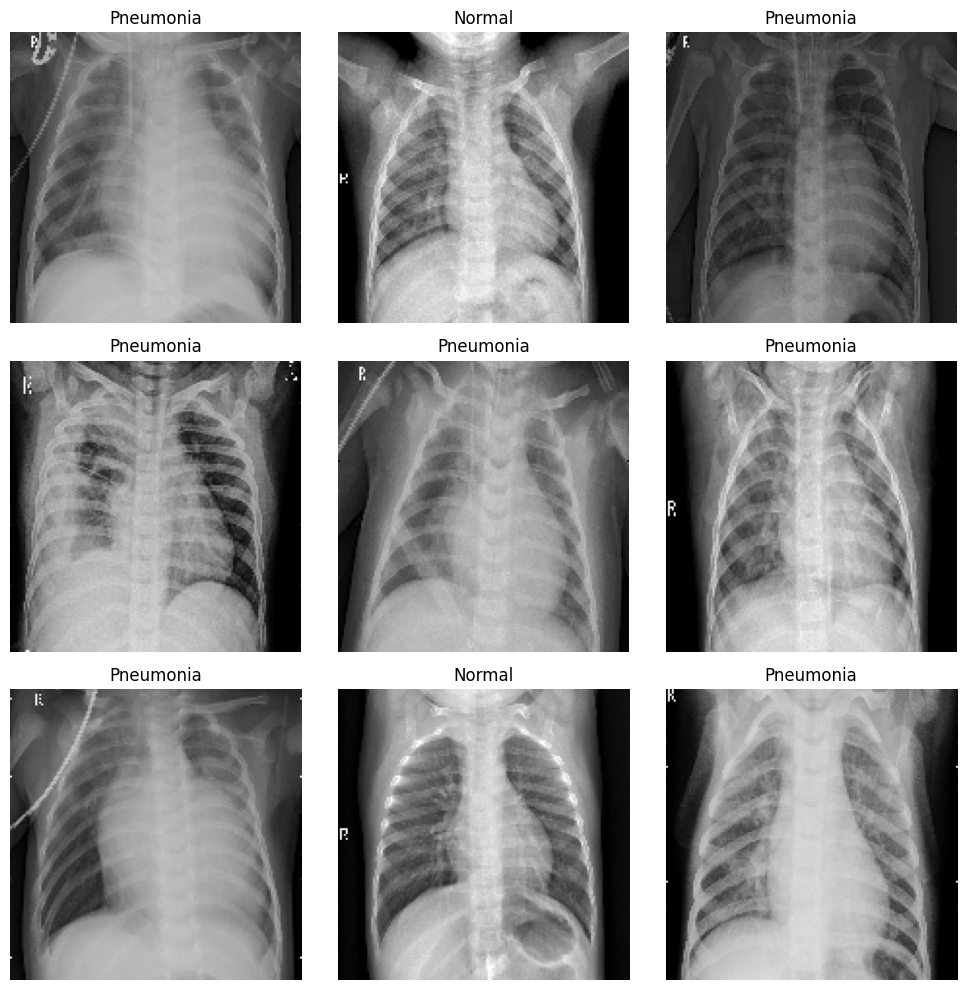

In [88]:
#Obtener un batch de imágenes del generador de entrenamiento
images, labels = next(train_generator)

#Mostrar las primeras 9 imágenes
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = images[i].reshape(image_size[0], image_size[1])
    label = "Pneumonia" if labels[i] == 1 else "Normal"
    plt.imshow(image, cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Implementación del Modelo

In [91]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)), #Primera capa convolucional
    BatchNormalization(), #Normalizacion por lotes
    MaxPooling2D(2, 2), #Downsampling
    
    Conv2D(64, (3, 3), activation='relu'), #Segunda capa convolucional
    BatchNormalization(), #Normalizacion
    MaxPooling2D(2, 2), #Max pooling
    
    Conv2D(128, (3, 3), activation='relu'), #Tercera capa convolucional
    BatchNormalization(), #Normalizacion
    MaxPooling2D(2, 2), #Max pooling
    
    Conv2D(256, (3, 3), activation='relu'),  # Capa adicional
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Flatten(), #"Aplana" la salida para conectarla a capas densas
    Dense(128, activation='relu'),  # Capa densa
    Dropout(0.5), #Dropout al 50% para evitar overfitting
    Dense(1, activation='sigmoid')  #Capa de salida para clasificacion binaria
])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,995,649 (7.61 MB)

 Trainable params: 1,994,689 (7.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [93]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),  #Adam con learning rate más bajo (para mejor estabilidad)
    loss='binary_crossentropy',            #Perdida especifica para clasificacion binaria
    metrics=['accuracy', 
             Precision(name='precision'),  #Para medir precision (evitar falsos positivos)
             Recall(name='recall'),        #Para medir sensibilidad (evitar falsos negativos)
             AUC(name='auc')]              #Para medir area bajo la curva ROC
)

# Entrenamiento del Modelo

In [94]:
early_stop = EarlyStopping(
    monitor='val_loss', #Monitorea la perdida en validacion
    patience=3, #Espera 3 epochs antes de detener
    restore_best_weights=True #Recupera los mejores pesos al final
)

checkpoint = ModelCheckpoint('mejor_modelo.h5', #Ruta donde guardar el mejor modelo
                             monitor='val_loss', #Basado en la perdida de validacion
                             save_best_only=True, #Solo se guarda el modelo si mejora
                             verbose=1
)

In [95]:
history = model.fit(
    train_generator, #Datos de entrenamiento
    epochs=10,
    validation_data=val_generator, #Datos de validacion
    callbacks=[early_stop, checkpoint] #EarlyStopping y guardado del mejor modelo
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.8951 - auc: 0.9214 - loss: 0.3317 - precision: 0.9307 - recall: 0.9294
Epoch 1: val_loss improved from inf to 4.56502, saving model to mejor_modelo.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 164s 984ms/step - accuracy: 0.8954 - auc: 0.9217 - loss: 0.3309 - precision: 0.9309 - recall: 0.9295 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 4.5650 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.9720 - auc: 0.9941 - loss: 0.0757 - precision: 0.9799 - recall: 0.9825
Epoch 2: val_loss did not improve from 4.56502
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 840ms/step - accuracy: 0.9720 - auc: 0.9941 - loss: 0.0757 - precision: 0.9799 - recall: 0.9825 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 8.1004 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.9784 - auc: 0.9969 - loss: 0.0583 - precision: 0.9855 - recall: 0.9855
Epoch 3: val_loss did not improve from 4.56502
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 831ms/step - accuracy: 0.9784 - auc: 0.9969 - loss: 0.0583 - precision: 0.9855 - recall: 0.9855 - val_accuracy: 0.5000 - val

163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 820ms/step - accuracy: 0.9841 - auc: 0.9985 - loss: 0.0396 - precision: 0.9881 - recall: 0.9908 - val_accuracy: 0.5625 - val_auc: 0.8125 - val_loss: 2.6735 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.9894 - auc: 0.9994 - loss: 0.0287 - precision: 0.9931 - recall: 0.9925
Epoch 5: val_loss improved from 2.67352 to 0.38801, saving model to mejor_modelo.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 820ms/step - accuracy: 0.9894 - auc: 0.9994 - loss: 0.0287 - precision: 0.9931 - recall: 0.9925 - val_accuracy: 0.7500 - val_auc: 1.0000 - val_loss: 0.3880 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.9899 - auc: 0.9994 - loss: 0.0278 - precision: 0.9941 - recall: 0.9922
Epoch 6: val_loss did not improve from 0.38801
163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 819ms/step - accuracy: 0.9899 - auc: 0.9994 - loss: 0.0278 - precision: 0.9941 - recall: 0.9922 - val_accuracy: 0.6250 - val_auc: 0.9375 - val_loss: 1.3540 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.9933 - auc: 0.9998 - loss: 0.0172 - precision: 0.9945 - recall: 0.9965
Epoch 7: val_loss improved from 0.38801 to 0.26237, saving model to mejor_modelo.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 821ms/step - accuracy: 0.9934 - auc: 0.9998 - loss: 0.0172 - precision: 0.9945 - recall: 0.9965 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.2624 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.9943 - auc: 0.9998 - loss: 0.0159 - precision: 0.9965 - recall: 0.9958
Epoch 8: val_loss did not improve from 0.26237
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 849ms/step - accuracy: 0.9943 - auc: 0.9998 - loss: 0.0158 - precision: 0.9966 - recall: 0.9958 - val_accuracy: 0.6250 - val_auc: 0.9375 - val_loss: 1.4636 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.9966 - auc: 0.9999 - loss: 0.0112 - precision: 0.9982 - recall: 0.9972
Epoch 9: val_loss did not improve from 0.26237
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 875ms/step - accuracy: 0.9966 - auc: 0.9999 - loss: 0.0112 - precision: 0.9982 - recall: 0.9972 - val_accuracy: 0.6875 - val

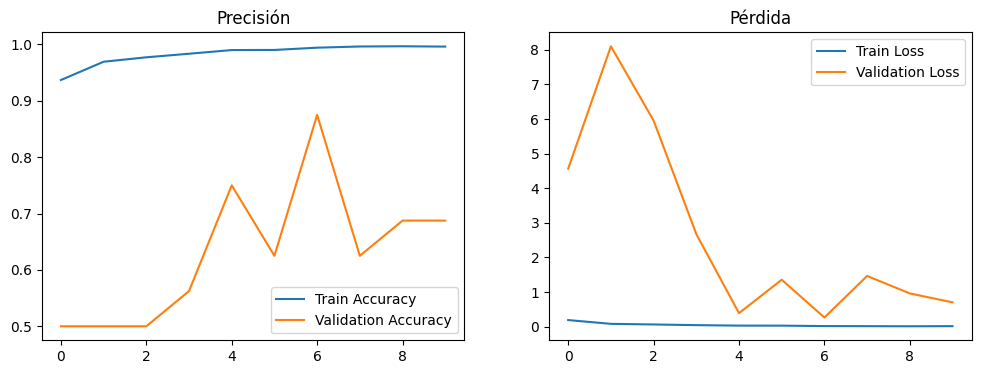

In [100]:
#Graficas de precision y perdida para entrenamiento y validacion a lo largo de las epocas
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pérdida')
plt.legend()
plt.show()

# Validación del Modelo

Correr esta parte del codigo con "chest_xray/test" y "mejor_modelo.h5".

In [103]:
model = load_model('mejor_modelo.h5')  #Subir el mejor modelo

In [ ]:
test_dir = r'tu/ruta/chest_xray/test'  #Ruta de la carpeta de test
image_size = (150, 150)
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255)  
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True  
)

In [99]:
loss, acc, precision, recall, auc = model.evaluate(test_generator)  #Evaluar todas las metricas
print(f"\nPrecisión (accuracy): {acc:.4f}")
print(f"Precisión (precision): {precision:.4f}")
print(f"Sensibilidad (recall): {recall:.4f}")
print(f"AUC: {auc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.7904 - auc: 0.8431 - loss: 1.3742 - precision: 0.7466 - recall: 0.9952

Precisión (accuracy): 0.7981
Precisión (precision): 0.7578
Sensibilidad (recall): 0.9949
AUC: 0.8443


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


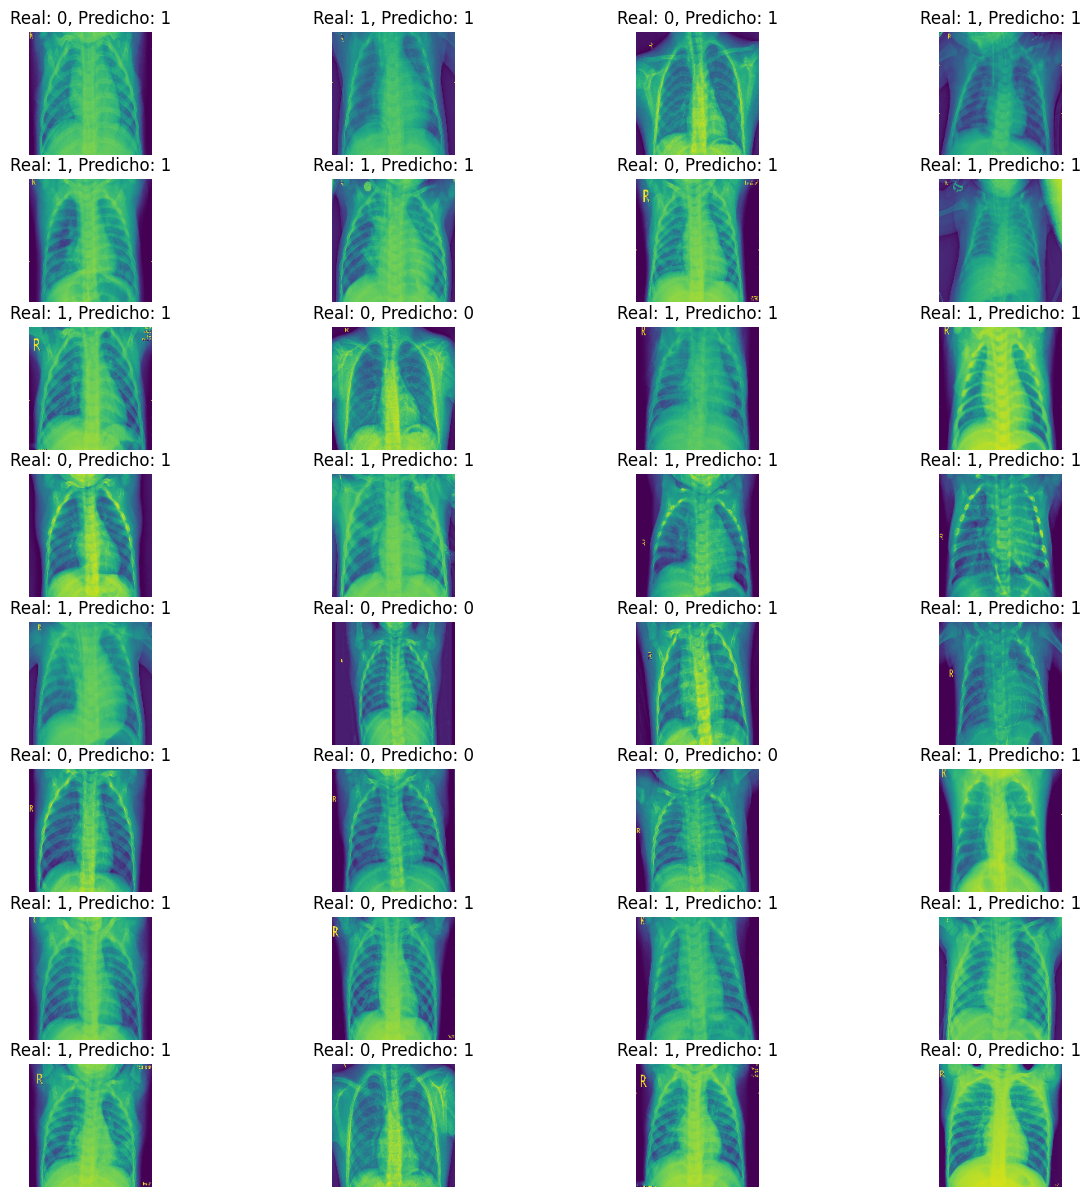

In [101]:
#Obtener un batch
test_images, test_labels = next(test_generator)

#Predecir
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int).flatten()

#Mostrar 9 imagenes con sus predicciones
plt.figure(figsize=(15, 15))
for i in range(32):
    plt.subplot(8, 4, i+1)
    plt.imshow(test_images[i])
    plt.title(f"Real: {int(test_labels[i])}, Predicho: {predicted_labels[i]}")
    plt.axis('off')
plt.show()